In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

plt.style.use('seaborn-v0_8-whitegrid')

BASE_DIR = os.path.join("..", "data")
DB_PATH = os.path.join(BASE_DIR, "music_warehouse.duckdb")

In [ ]:
# Configs
LABEL_KEYS = ['universal', 'sony', 'warner']
TICKER_MAP = {'UMG.AS': 'universal', 'WMG': 'warner', 'SONY': 'sony'}
DISPLAY_NAMES = {'universal': 'Universal', 'sony': 'Sony', 'warner': 'Warner'}
COLORS = {'universal': '#FF5733', 'sony': '#3366CC', 'warner': '#33CC33'}
LABELS_CONFIG = [(k, DISPLAY_NAMES[k]) for k in LABEL_KEYS]
ROLLING_WINDOW_DAYS = 7
PLOT_START_DATE = pd.Timestamp('2025-12-03')


## 1. Load Data from DuckDB

In [ ]:
con = duckdb.connect(DB_PATH, read_only=True)
tables = con.sql("SHOW TABLES").df()
print("Available tables:", tables['name'].tolist())

Available tables: ['__perm_test', 'daily_charts', 'dim_labels', 'dim_track_metadata', 'fact_market_share', 'int_charts_with_track_id', 'int_label_relationships', 'int_labels_normalized', 'raw_musicbrainz_labels', 'raw_stock_prices', 'stg_combined_charts', 'stg_dim_labels_normalized', 'stg_musicbrainz_labels', 'stg_track_metadata_normalized']


In [ ]:
market_share_df = con.sql("""
    SELECT 
        chart_date,
        parent_group,
        total_streams,
        track_count,
        market_share_pct
    FROM fact_market_share
    WHERE parent_group IN ('Universal Music Group', 'Sony Music Entertainment', 'Warner Music Group')
    ORDER BY chart_date, parent_group
""").df()

print(f"Market share data: {len(market_share_df)} rows")
print(f"Date range: {market_share_df['chart_date'].min()} to {market_share_df['chart_date'].max()}")
market_share_df.head()

Market share data: 132 rows
Date range: 2025-11-26 00:00:00 to 2026-01-16 00:00:00


,chart_date,parent_group,total_streams,track_count,market_share_pct
0,2025-11-26,Sony Music Entertainment,194320611.0,30,0.177123
1,2025-11-26,Universal Music Group,452519830.0,68,0.412471
2,2025-11-26,Warner Music Group,263937663.0,43,0.240579
3,2025-12-03,Sony Music Entertainment,273981872.0,33,0.221614
4,2025-12-03,Universal Music Group,500387925.0,63,0.404745


In [ ]:
# Run 'python scripts/fetch_financials.py' to load stock prices
stock_df = con.sql("""
    SELECT 
        date,
        ticker,
        company_name,
        close,
        volume
    FROM raw_stock_prices
    ORDER BY date, ticker
""").df()
print(f"\nStock price data: {len(stock_df)} rows")
print(f"Date range: {stock_df['date'].min()} to {stock_df['date'].max()}")
display(stock_df.head())


Stock price data: 1559 rows
Date range: 2023-12-26 00:00:00 to 2026-01-16 00:00:00


,date,ticker,company_name,close,volume
0,2023-12-26,SONY,Sony Group Corporation,18.516001,3302000
1,2023-12-26,WMG,Warner Music Group,33.560852,693500
2,2023-12-27,SONY,Sony Group Corporation,18.622971,2927000
3,2023-12-27,UMG.AS,Universal Music Group,24.867224,859092
4,2023-12-27,WMG,Warner Music Group,33.866478,1052700


In [ ]:
con.close()

## 2. Market Share Trend Analysis

In [ ]:
# Pivot market share for time series analysis
market_share_pivot = market_share_df.pivot(
    index='chart_date', 
    columns='parent_group', 
    values='market_share_pct'
).reset_index()

market_share_pivot['chart_date'] = pd.to_datetime(market_share_pivot['chart_date'])
market_share_pivot = market_share_pivot.set_index('chart_date').sort_index()
market_share_pivot.columns = ['sony', 'universal', 'warner']

print("Market Share Summary Statistics:")
display((market_share_pivot * 100).describe().round(2))

Market Share Summary Statistics:


,sony,universal,warner
count,44.00,44.00,44.00
mean,20.07,40.81,21.33
std,5.82,2.71,3.81
min,11.58,36.68,11.50
25%,13.53,38.51,18.97
50%,22.09,40.93,21.31
75%,23.89,42.67,24.18
max,31.28,46.06,27.42


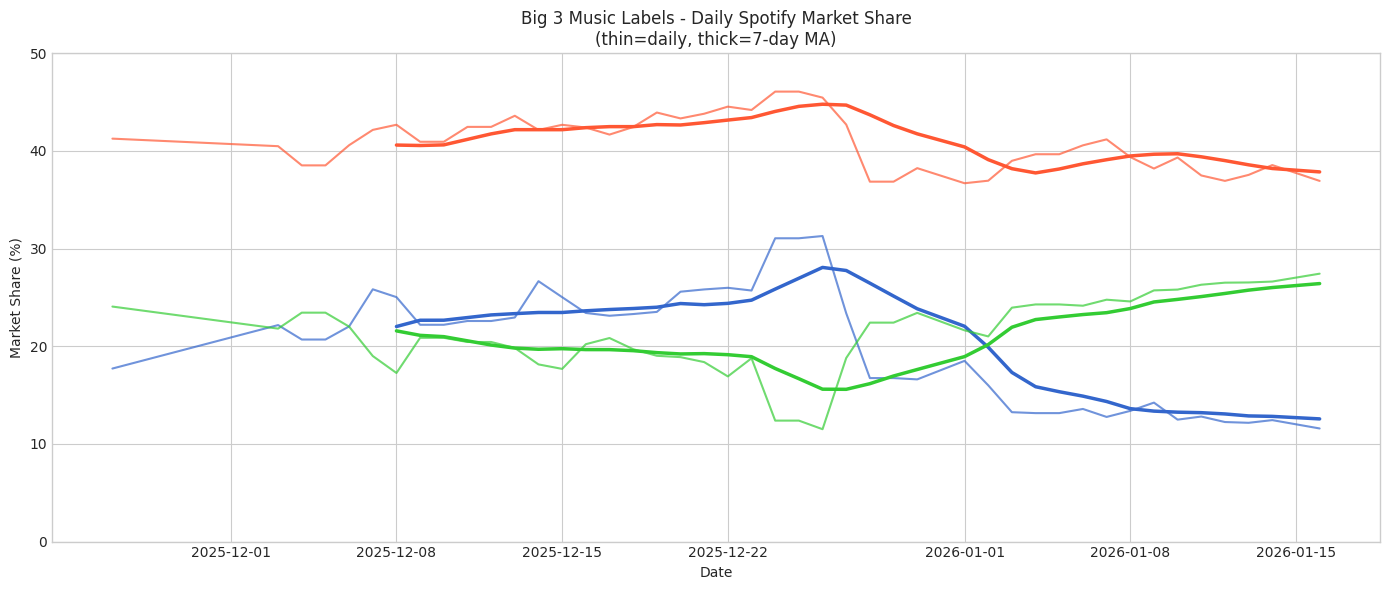

In [ ]:
# Plot market share over time
fig, ax = plt.subplots(figsize=(14, 6))

for label in LABEL_KEYS:
    ax.plot(
        market_share_pivot.index,
        market_share_pivot[label] * 100,
        label=DISPLAY_NAMES[label],
        linewidth=1.5,
        color=COLORS[label],
        alpha=0.7,
    )
    # Add 7-day moving average
    ma = market_share_pivot[label].rolling(ROLLING_WINDOW_DAYS).mean() * 100
    ax.plot(
        market_share_pivot.index,
        ma,
        linewidth=2.5,
        color=COLORS[label],
        linestyle='-',
    )

ax.set_xlabel('Date')
ax.set_ylabel('Market Share (%)')
ax.set_title('Big 3 Music Labels - Daily Spotify Market Share\n(thin=daily, thick=7-day MA)')
ax.set_ylim(0, 50)
plt.tight_layout()
plt.show()

## 3. Feature Engineering: Momentum Signals

In [ ]:
# Calculate momentum features for each label
for label in LABEL_KEYS:
    # Moving averages
    market_share_pivot[f'{label}_ma{ROLLING_WINDOW_DAYS}'] = market_share_pivot[label].rolling(ROLLING_WINDOW_DAYS).mean()
    # market_share_pivot[f'{label}_ma30'] = market_share_pivot[label].rolling(30).mean() # Future: enable with longer history
    
    # Rate of change (momentum)
    market_share_pivot[f'{label}_roc{ROLLING_WINDOW_DAYS}'] = market_share_pivot[label].pct_change(ROLLING_WINDOW_DAYS)
    # market_share_pivot[f'{label}_roc30'] = market_share_pivot[label].pct_change(30) # Future: enable with longer history
    
    # Deviation from mean (z-score over rolling window)
    rolling_mean = market_share_pivot[label].rolling(ROLLING_WINDOW_DAYS).mean()
    rolling_std = market_share_pivot[label].rolling(ROLLING_WINDOW_DAYS).std()
    market_share_pivot[f'{label}_zscore'] = (market_share_pivot[label] - rolling_mean) / rolling_std

# Show latest momentum signals
momentum_cols = [col for col in market_share_pivot.columns if 'roc' in col or 'zscore' in col]
print("Latest Momentum Signals:")
display(market_share_pivot[momentum_cols].tail(5).round(4))

Latest Momentum Signals:


,universal_roc7,universal_zscore,sony_roc7,sony_zscore,warner_roc7,warner_zscore
chart_date,,,,,,
2026-01-11,-0.0548,-1.5005,-0.0266,-0.6711,0.0831,1.4400
2026-01-12,-0.0688,-1.3271,-0.0694,-1.1930,0.0918,1.2195
2026-01-13,-0.0746,-0.6981,-0.1044,-0.9697,0.0986,0.9860
2026-01-14,-0.0639,0.3729,-0.0255,-0.5143,0.0750,0.8494
2026-01-16,-0.0620,-1.0432,-0.1346,-1.1894,0.1157,1.7689


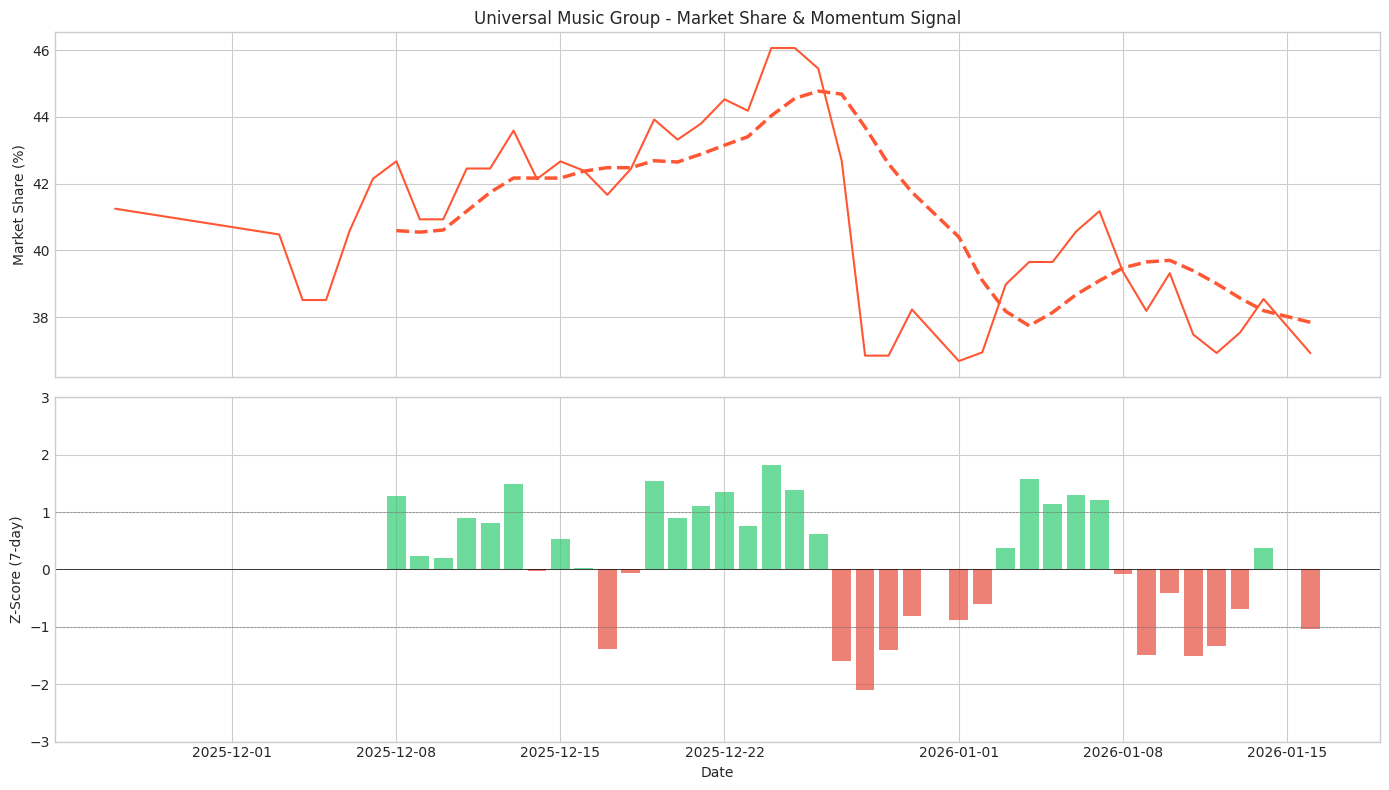

In [ ]:
# Plot momentum (z-score) for Universal as an example
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ma_col = f"universal_ma{ROLLING_WINDOW_DAYS}"

# Top: Market Share
axes[0].plot(
    market_share_pivot.index,
    market_share_pivot['universal'] * 100,
    color=COLORS['universal'],
    linewidth=1.5,
    label='Daily',
)
axes[0].plot(
    market_share_pivot.index,
    market_share_pivot[ma_col] * 100,
    color=COLORS['universal'],
    linewidth=2.5,
    linestyle='--',
    label=f'{ROLLING_WINDOW_DAYS}-day MA',
)
axes[0].set_ylabel('Market Share (%)')
axes[0].set_title('Universal Music Group - Market Share & Momentum Signal')

# Bottom: Z-Score Momentum Signal
axes[1].bar(
    market_share_pivot.index,
    market_share_pivot['universal_zscore'],
    color=np.where(market_share_pivot['universal_zscore'] > 0, '#2ECC71', '#E74C3C'),
    alpha=0.7,
 )
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axhline(1, color='gray', linewidth=0.5, linestyle='--')
axes[1].axhline(-1, color='gray', linewidth=0.5, linestyle='--')
axes[1].set_ylabel(f'Z-Score ({ROLLING_WINDOW_DAYS}-day)')
axes[1].set_xlabel('Date')
axes[1].set_ylim(-3, 3)

plt.tight_layout()
plt.show()

## 4. Stock Price Integration & Correlation Analysis

In [ ]:
# Pivot stock prices (normalize tickers to label keys via shared config)
stock_pivot = stock_df.pivot(
    index='date',
    columns='ticker',
    values='close',
).rename(columns=TICKER_MAP)

stock_pivot.index = pd.to_datetime(stock_pivot.index)

# Calculate log returns
stock_returns = np.log(stock_pivot / stock_pivot.shift(1))
stock_returns.columns = [f'{col}_return' for col in stock_returns.columns]

print("Stock Returns Summary:")
display((stock_returns * 100).describe().round(3))

Stock Returns Summary:


,sony_return,universal_return,warner_return
count,501.000,518.000,501.000
mean,0.058,-0.029,-0.010
std,1.805,1.927,1.736
min,-6.905,-26.837,-9.036
25%,-0.929,-0.826,-0.802
50%,-0.034,0.058,0.000
75%,0.946,0.787,0.949
max,8.596,7.092,5.850


In [ ]:
# Merge market share with stock returns
# Market share is daily, stock data is trading days only
# Forward-fill market share to align with stock trading days

combined = market_share_pivot[LABEL_KEYS].copy()
combined = combined.join(stock_returns, how='inner')

# Calculate market share changes
for label in LABEL_KEYS:
    combined[f'{label}_ms_change'] = combined[label].diff()

print(f"Combined dataset: {len(combined)} trading days")
print(f"Date range: {combined.index.min()} to {combined.index.max()}")
display(combined.tail())

Combined dataset: 30 trading days
Date range: 2025-11-26 00:00:00 to 2026-01-16 00:00:00


,universal,sony,warner,sony_return,universal_return,warner_return,universal_ms_change,sony_ms_change,warner_ms_change
2026-01-09,0.381857,0.142244,0.257124,-0.008352,0.043265,0.042153,-0.011743,0.008449,0.011315
2026-01-12,0.369231,0.122375,0.265038,0.005575,0.004943,-0.001937,-0.012626,-0.019869,0.007914
2026-01-13,0.375366,0.121588,0.265247,-0.031057,-0.009005,0.017932,0.006134,-0.000787,0.000209
2026-01-14,0.385414,0.124339,0.266182,-0.013196,-0.007263,-0.007646,0.010048,0.002751,0.000935
2026-01-16,0.369200,0.115791,0.274248,-0.002906,-0.013806,-0.009436,-0.016214,-0.008548,0.008065


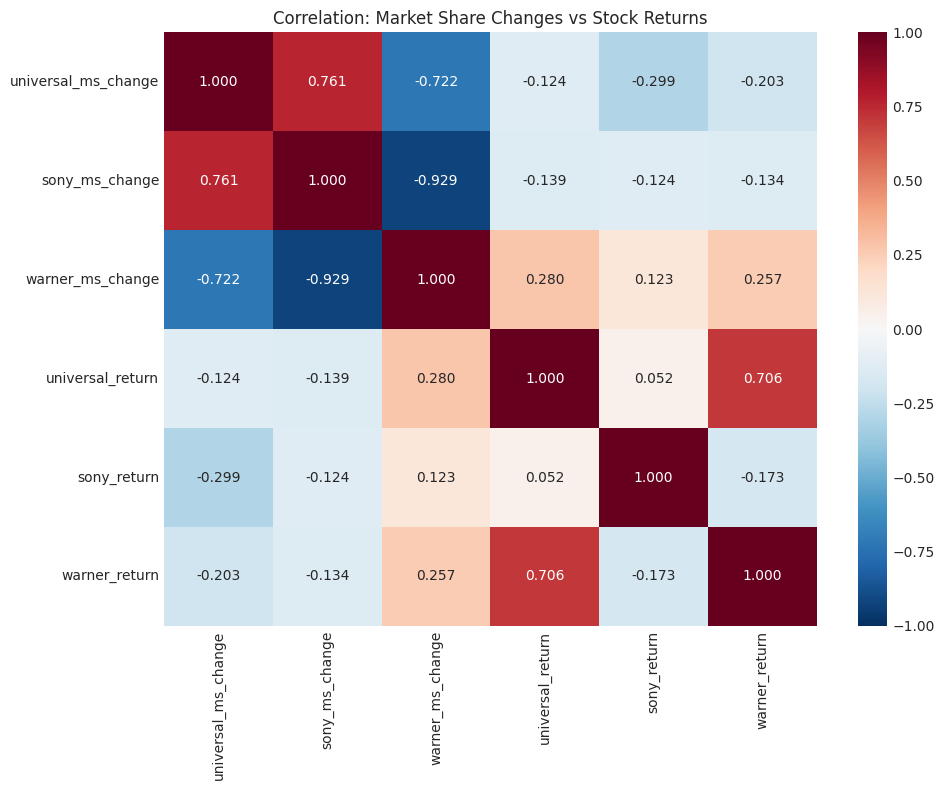

In [ ]:
# Correlation matrix of market share change vs stock returns
corr_cols = [f'{label}_ms_change' for label in LABEL_KEYS] + [f'{label}_return' for label in LABEL_KEYS]

corr_matrix = combined[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, fmt='.3f', ax=ax)
ax.set_title('Correlation: Market Share Changes vs Stock Returns')
plt.tight_layout()
plt.show()

## 5. Lead/Lag Analysis: Does Market Share Predict Stock Returns?

In [ ]:
def calculate_lead_lag_correlations(signal: pd.Series, target: pd.Series, max_lag: int = 10) -> pd.DataFrame:
    """
    Calculate correlations between signal and target at various lags.
    Positive lag = signal leads target (predictive).
    """
    results = []
    for lag in range(-max_lag, max_lag + 1):
        if lag > 0:
            # Signal leads target (predictive power)
            corr = signal.shift(lag).corr(target)
        elif lag < 0:
            # Target leads signal
            corr = signal.corr(target.shift(-lag))
        else:
            corr = signal.corr(target)
        results.append({'lag': lag, 'correlation': corr})
    return pd.DataFrame(results)

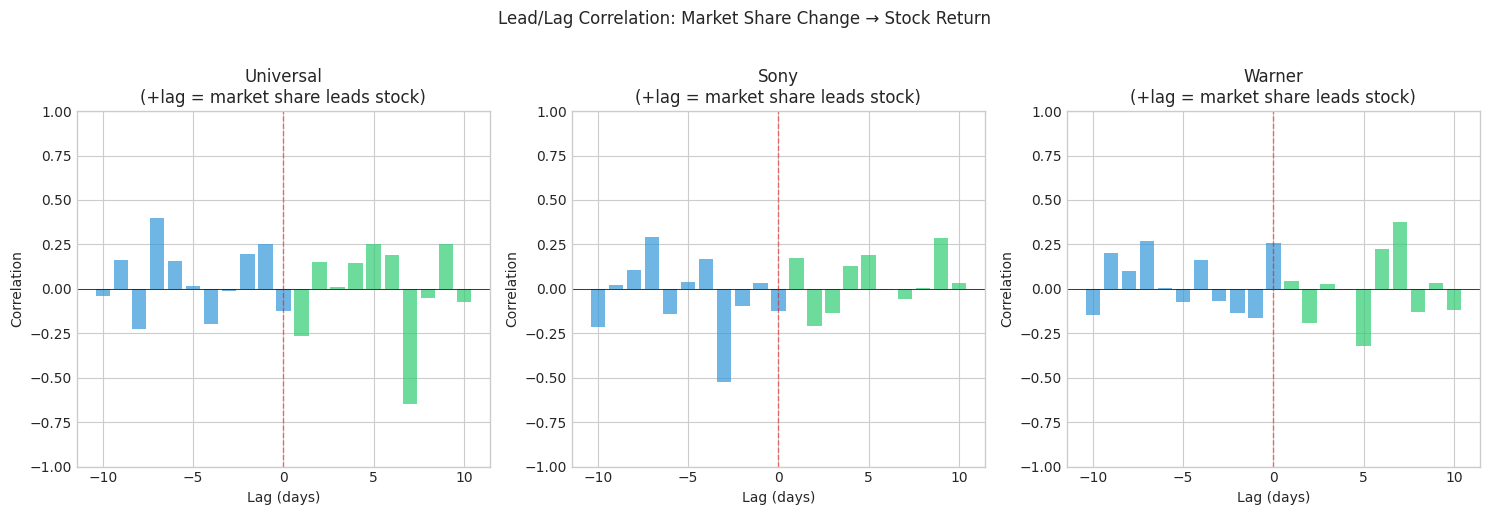

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, label in enumerate(LABEL_KEYS):
    signal = combined[f'{label}_ms_change'].dropna()
    target = combined[f'{label}_return'].dropna()
    
    lag_corr = calculate_lead_lag_correlations(signal, target, max_lag=10)
    
    lag_bar_colors = ['#2ECC71' if x > 0 else '#3498DB' for x in lag_corr['lag']]
    axes[idx].bar(lag_corr['lag'], lag_corr['correlation'], color=lag_bar_colors, alpha=0.7)
    axes[idx].axhline(0, color='black', linewidth=0.5)
    axes[idx].axvline(0, color='red', linewidth=1, linestyle='--', alpha=0.5)
    axes[idx].set_xlabel('Lag (days)')
    axes[idx].set_ylabel('Correlation')
    axes[idx].set_title(f'{DISPLAY_NAMES[label]}\n(+lag = market share leads stock)')
    axes[idx].set_ylim(-1.0, 1.0)

plt.suptitle('Lead/Lag Correlation: Market Share Change → Stock Return', y=1.02)
plt.tight_layout()
plt.show()

## 6. Market Share vs Stock Price

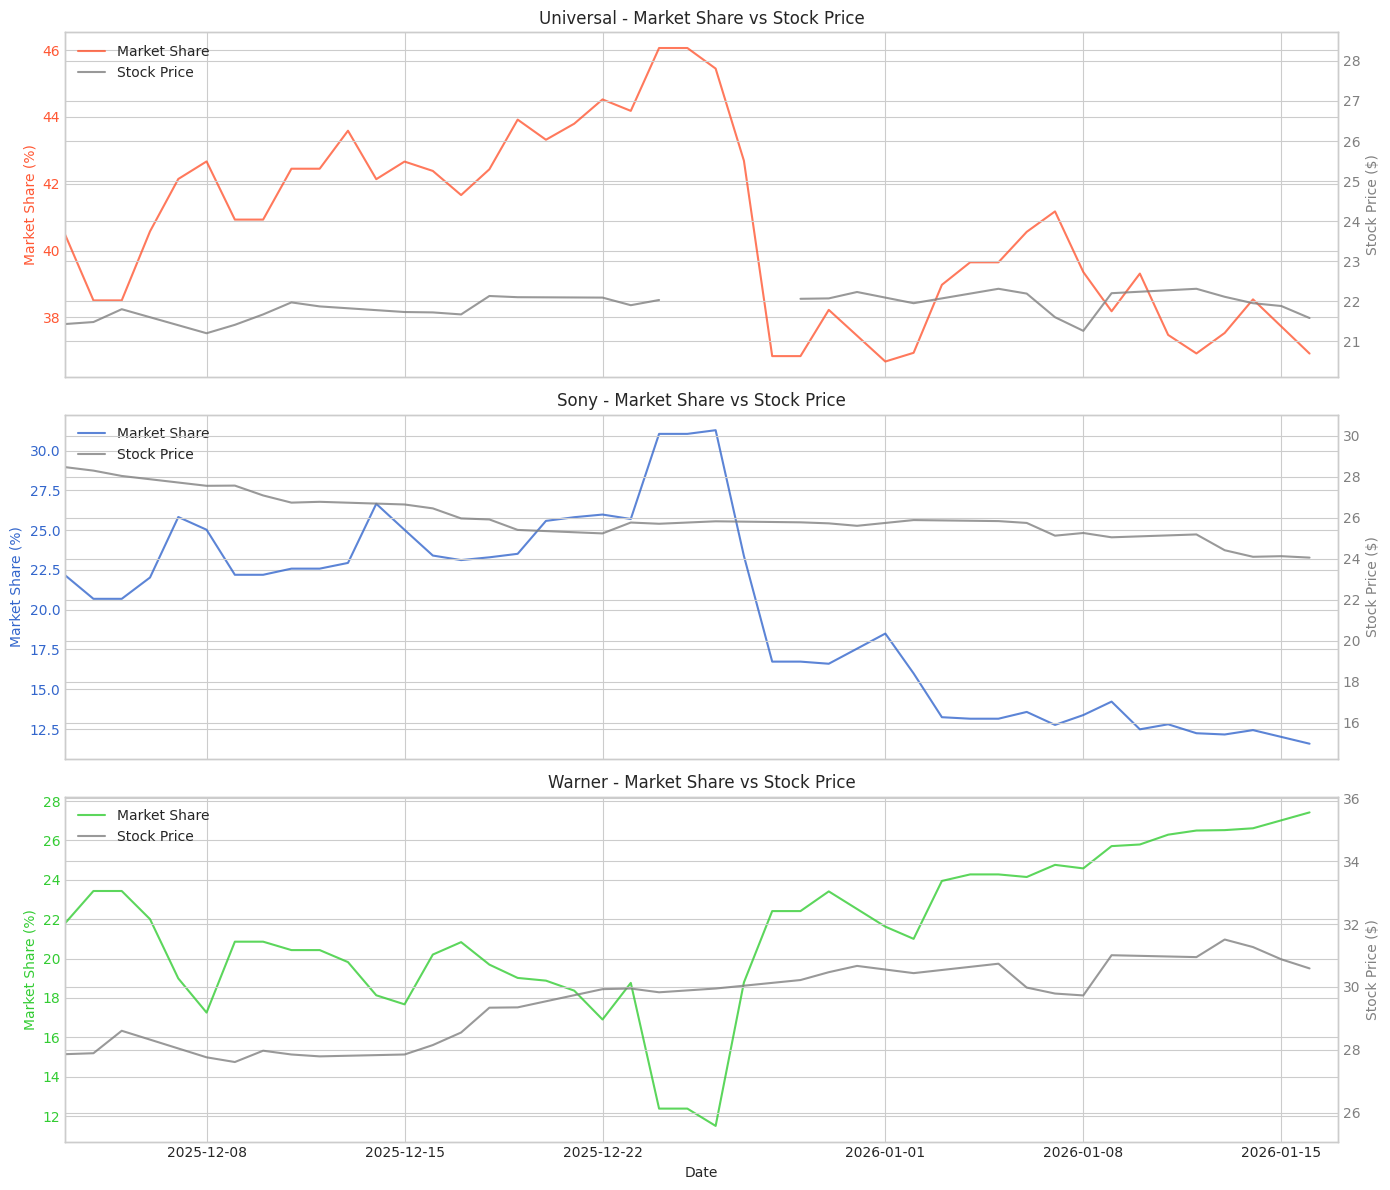

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for idx, (key, display_name) in enumerate(LABELS_CONFIG):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    # Market Share (left axis)
    line1 = ax1.plot(
        market_share_pivot.index,
        market_share_pivot[key] * 100,
        color=COLORS[key],
        linewidth=1.5,
        alpha=0.8,
        label='Market Share',
    )
    ax1.set_ylabel('Market Share (%)', color=COLORS[key])
    ax1.tick_params(axis='y', labelcolor=COLORS[key])
    
    # Stock Price (right axis)
    line2 = ax2.plot(
        stock_pivot.index,
        stock_pivot[key],
        color='gray',
        linewidth=1.5,
        alpha=0.8,
        label='Stock Price',
    )
    ax2.set_ylabel('Stock Price ($)', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    ax1.set_title(f'{display_name} - Market Share vs Stock Price')
    
    # Combined legend
    lines = line1 + line2
    labels_legend = [l.get_label() for l in lines]
    ax1.legend(lines, labels_legend, loc='upper left')

axes[-1].set_xlabel('Date')
axes[-1].set_xlim(left=PLOT_START_DATE, right=pd.Timestamp.today().normalize())
plt.tight_layout()
plt.show()

In [ ]:
# Statistical test: Is the correlation significant?
for label in LABEL_KEYS:
    ms_change = combined[f'{label}_ms_change'].dropna()
    stock_ret = combined[f'{label}_return'].dropna()
    
    # Align series
    common_idx = ms_change.index.intersection(stock_ret.index)
    ms_change = ms_change.loc[common_idx]
    stock_ret = stock_ret.loc[common_idx]
    
    corr, pvalue = stats.pearsonr(ms_change, stock_ret)
    print(f"\n{DISPLAY_NAMES[label]}:")
    print(f"  Correlation: {corr:.4f}")
    print(f"  P-value: {pvalue:.4f}")
    print(f"  Significant at 5%: {'Yes' if pvalue < 0.05 else 'No'}")


Universal:
  Correlation: -0.1238
  P-value: 0.5383
  Significant at 5%: No

Sony:
  Correlation: -0.1239
  P-value: 0.5219
  Significant at 5%: No

Warner:
  Correlation: 0.2574
  P-value: 0.1777
  Significant at 5%: No


## 7. Potential future enhancements

- **Cointegration Signal Integration**: Integrate with the [cointegration-analysis](https://github.com/gustavlan/cointegration-analysis) framework to treat market share time series as potentially cointegrated pairs (e.g., Sony vs. Universal). By modeling the market share spread as a mean-reverting Ornstein-Uhlenbeck process, we could generate trading signals when the spread deviates significantly from its equilibrium (high z-score). This assumes that market share shifts are zero-sum in the short term and that stock prices will eventually reflect these structural reversions, offering a fundamental "pairs trading" signal distinct from pure price action.
- Momentum Divergence: When market share z-score diverges significantly from 0, does it predict mean-reversion in stock price?
- Relative Strength: When one label gains share at the expense of another, is there a paired trade opportunity?
- Event Detection: Can we detect new releases or viral moments that precede stock movements?
- Backtest simple trading strategies based on market share signals
- Add quarterly earnings data to correlate with cumulative market share changes
- Expand to other streaming platforms (Apple Music, Amazon)
- Apply Granger causality tests for statistical rigor